# Задание 1

1. Загрузить, посмотреть, определить количество строк и объединить 3 датасета: marketing_campaign.csv, users.csv и subscribers.csv.
1. Определить типы и статистики колонок.
1. Определить эффективность маркетинговых каналов по привлечению платящих игроков.
1. Определить количество игроков в каждой возрастной группе.
1. Определить самую раннюю дату подписки на сервис.
1. Определить портрет аудитории удержанных подписчиков (по возрасту и языку).
1. Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog, curve_fit

## Загрузить, посмотреть, определить количество строк и объединить 3 датасета: marketing_campaign.csv, users.csv и subscribers.csv.

In [2]:
marketing_campaign = pd.read_csv('./marketing_campaign.csv')
subscribers = pd.read_csv('./subscribers.csv')
users = pd.read_csv('./users.csv')

In [3]:
marketing_campaign.shape[0]

10037

In [4]:
marketing_campaign.shape[0] == users.shape[0] == subscribers.shape[0]

True

**Описание датасета**

1) `user_id`: идентификатор пользователя

2) `date_served`: дата события

3) `marketing_channel`: рекламный канал

4) `variant`: показанный вариант рекламы

5) `converted`: конверсия в покупку, 1 - пользователь совершил покупку, 0 - нет

6) `language_displayed`: язык рекламного сообщения

7) `language_preferred`: предпочитаемый пользователем язык

8) `age_group`: возрастная группа пользователя

9) `date_subscribed`: дата подписки на сервис

10) `date_canceled`: дата отказа от подписки

11) `subscribing_channel`: с какого рекламного канал пришел пользователь, когда подписался на сервис

12) `is_retained`: удержание, 1 - пользователь продолжает пользоваться услугами сервиса, 0 - пользователь отвалился 

Источник: https://www.kaggle.com/kavitabhagwani/marketing-campaign

In [5]:
dataset = pd.concat([marketing_campaign.set_index('user_id'),
                     subscribers.set_index('user_id'),
                     users.set_index('user_id')], 
                    axis=1)

In [6]:
dataset.head(3)

,date_served,marketing_channel,variant,language_displayed,converted,subscribing_channel,date_subscribed,date_canceled,is_retained,age_group,language_preferred
user_id,,,,,,,,,,,
a1000,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,0-18 years,English
a1001,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,19-24 years,English
a1002,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,24-30 years,English


## Определить типы и статистики колонок.

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10037 entries, a1000 to a11036
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date_served          10021 non-null  object
 1   marketing_channel    10022 non-null  object
 2   variant              10037 non-null  object
 3   language_displayed   10037 non-null  object
 4   converted            10022 non-null  object
 5   subscribing_channel  1856 non-null   object
 6   date_subscribed      1856 non-null   object
 7   date_canceled        577 non-null    object
 8   is_retained          1856 non-null   object
 9   age_group            10037 non-null  object
 10  language_preferred   10037 non-null  object
dtypes: object(11)
memory usage: 941.0+ KB


In [11]:
dataset

,date_served,marketing_channel,variant,language_displayed,converted,subscribing_channel,date_subscribed,date_canceled,is_retained,age_group,language_preferred
user_id,,,,,,,,,,,
a1000,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,0-18 years,English
a1001,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,19-24 years,English
a1002,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,24-30 years,English
a1003,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,30-36 years,English
a1004,1/1/18,House Ads,personalization,English,True,House Ads,1/1/18,NaN,True,36-45 years,English
...,...,...,...,...,...,...,...,...,...,...,...
a11032,1/17/18,Email,control,German,True,Email,1/17/18,1/24/18,False,45-55 years,German
a11033,1/17/18,Email,control,German,True,Email,1/17/18,NaN,True,55+ years,German
a11034,1/5/18,Instagram,control,German,False,Email,1/17/18,NaN,True,55+ years,German


In [8]:
dataset.describe()

,date_served,marketing_channel,variant,language_displayed,converted,subscribing_channel,date_subscribed,date_canceled,is_retained,age_group,language_preferred
count,10021,10022,10037,10037,10022,1856,1856,577,1856,10037,10037
unique,31,5,2,4,2,5,31,115,2,7,4
top,1/15/18,House Ads,control,English,False,Instagram,1/16/18,4/2/18,True,19-24 years,English
freq,789,4733,5091,9793,8946,600,163,15,1279,1682,9275


Все колонки, кроме `is_retained` и `converted`, - это категориальные фичи. `is_retained` и `converted` в свою очередь бинарные

## Определить эффективность маркетинговых каналов по привлечению платящих игроков.

## Определить количество игроков в каждой возрастной группе

## Определить самую раннюю дату подписки на сервис

## Определить портрет аудитории удержанных подписчиков (по возрасту и языку).

## Проверить гипотезу о том, в каком варианте теста (control/personalization) больше конверсия (converted) и значимо ли это отличие статистически

# Задание 2

Цех может производить стулья и столы. На производство стула идет 5 единиц материала, на производство стола - 20 единиц (футов красного дерева). Стул требует 10 человеко-часов, стол - 15. Имеется 400 единиц материала и 450 человеко-часов. Прибыль при производстве стула - 45 долларов США, при производстве стола - 80 долларов США. Сколько надо сделать стульев и столов, чтобы получить максимальную прибыль?

> Решение

Пусть:

- x - количество произведенных стульев

- y - количество произведенных столов

У нас есть ограничения:
- 5x + 20y <= 400 (ограничение по материалам)
- 10x + 15y <= 450 (ограничение по человеко-часам)

Надо найти такие x, y, что 45x + 80y -> max при заданных условиях.


In [17]:
# Целевая функция (коэффициенты при переменных)
c = [-45, -80]

# Ограничения-неравенства (коэффициенты при переменных слева от знака <=)
A = [[5, 20], [10, 15]]
b = [400, 450]

# Границы переменных (нижняя и верхняя границы для каждой переменной)
x0_bounds = (0, None)  # для x (количество стульев)
x1_bounds = (0, None)  # для y (количество столов)

# Решаем задачу линейного программирования
res = linprog(c, A_ub=A, b_ub=b, bounds=[x0_bounds, x1_bounds], method='highs')

# Выводим результаты
print("Результат:")
print(f"Количество стульев: {int(res.x[0])}", )
print(f"Количество столов: {int(res.x[1])}")
print(f"Максимальная прибыль: {-res.fun}")

Результат:
Количество стульев: 24
Количество столов: 14
Максимальная прибыль: 2200.0


# Задание 3 

Средний накопленный доход на пользователя с сайта (cumulative ARPU) составил: day1 0.4$, day3 0.6$, day7 0.8$, day14 1.10$ , day21 1.30$, day30 1.40$. Подберите аппроксимирующую кривую и сделайте прогноз, сколько в среднем принесет денег пользователь на 90й день. Обоснуйте выбор одной из аппроксимирующей кривой вида: y = ab^x или y = aln(x) + b.

In [20]:
import numpy as np
from scipy.optimize import curve_fit

# Данные
days = np.array([1, 3, 7, 14, 21, 30])
revenue = np.array([0.4, 0.6, 0.8, 1.10, 1.30, 1.40])

# Функция для аппроксимации (y = ab^x)
def exponential_func(x, a, b):
    return a * (b ** x)

# Аппроксимация данных
popt_exp, pcov_exp = curve_fit(exponential_func, days, revenue)

# Прогноз на 90-й день
revenue_90 = exponential_func(90, *popt_exp)
print("Прогноз с использованием экспоненциальной кривой:", revenue_90)

Прогноз с использованием экспоненциальной кривой: 9.872703618978317


In [21]:
# Функция для аппроксимации (y = aln(x) + b)
def logarithmic_func(x, a, b):
    return a * np.log(x) + b

# Аппроксимация данных
popt_log, pcov_log = curve_fit(logarithmic_func, days, revenue)

# Прогноз на 90-й день
revenue_90_log = logarithmic_func(90, *popt_log)
print("Прогноз с использованием логарифмической кривой:", revenue_90_log)

Прогноз с использованием логарифмической кривой: 1.687325756038148


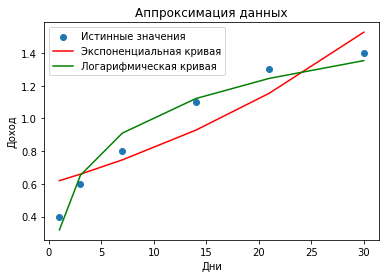

In [24]:
# Истинные значения
plt.scatter(days, revenue, label='Истинные значения')

# Аппроксимирующая экспоненциальная прямая
plt.plot(days, exponential_func(days, *popt_exp), label='Экспоненциальная кривая', color='r')

# Аппроксимирующая логарифмическая прямая
plt.plot(days, logarithmic_func(days, *popt_log), label='Логарифмическая кривая', color='g')

# Настройки графика
plt.title('Аппроксимация данных')
plt.xlabel('Дни')
plt.ylabel('Доход')
plt.legend()
plt.show()


Кажется, что логарифмическая кривая лучше отражает суть процесса. поэтому для предсказания на 90й день будем использовать именно её, то есть на 90й день доход будет 1.687